# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from nltk.tokenize import TweetTokenizer
import nltk
from nltk.stem.snowball import SnowballStemmer
import string
from string import punctuation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import MaxAbsScaler

In [146]:
data = pd.read_csv('train.csv')

In [147]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [148]:
data.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [149]:
data = data.fillna('')
data.head()

,id,keyword,location,text,target
0,1,,,Our Deeds are the Reason of this #earthquake M...,1
1,4,,,Forest fire near La Ronge Sask. Canada,1
2,5,,,All residents asked to 'shelter in place' are ...,1
3,6,,,"13,000 people receive #wildfires evacuation or...",1
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1


In [150]:
data.isna().sum().sum()

0

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?
2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

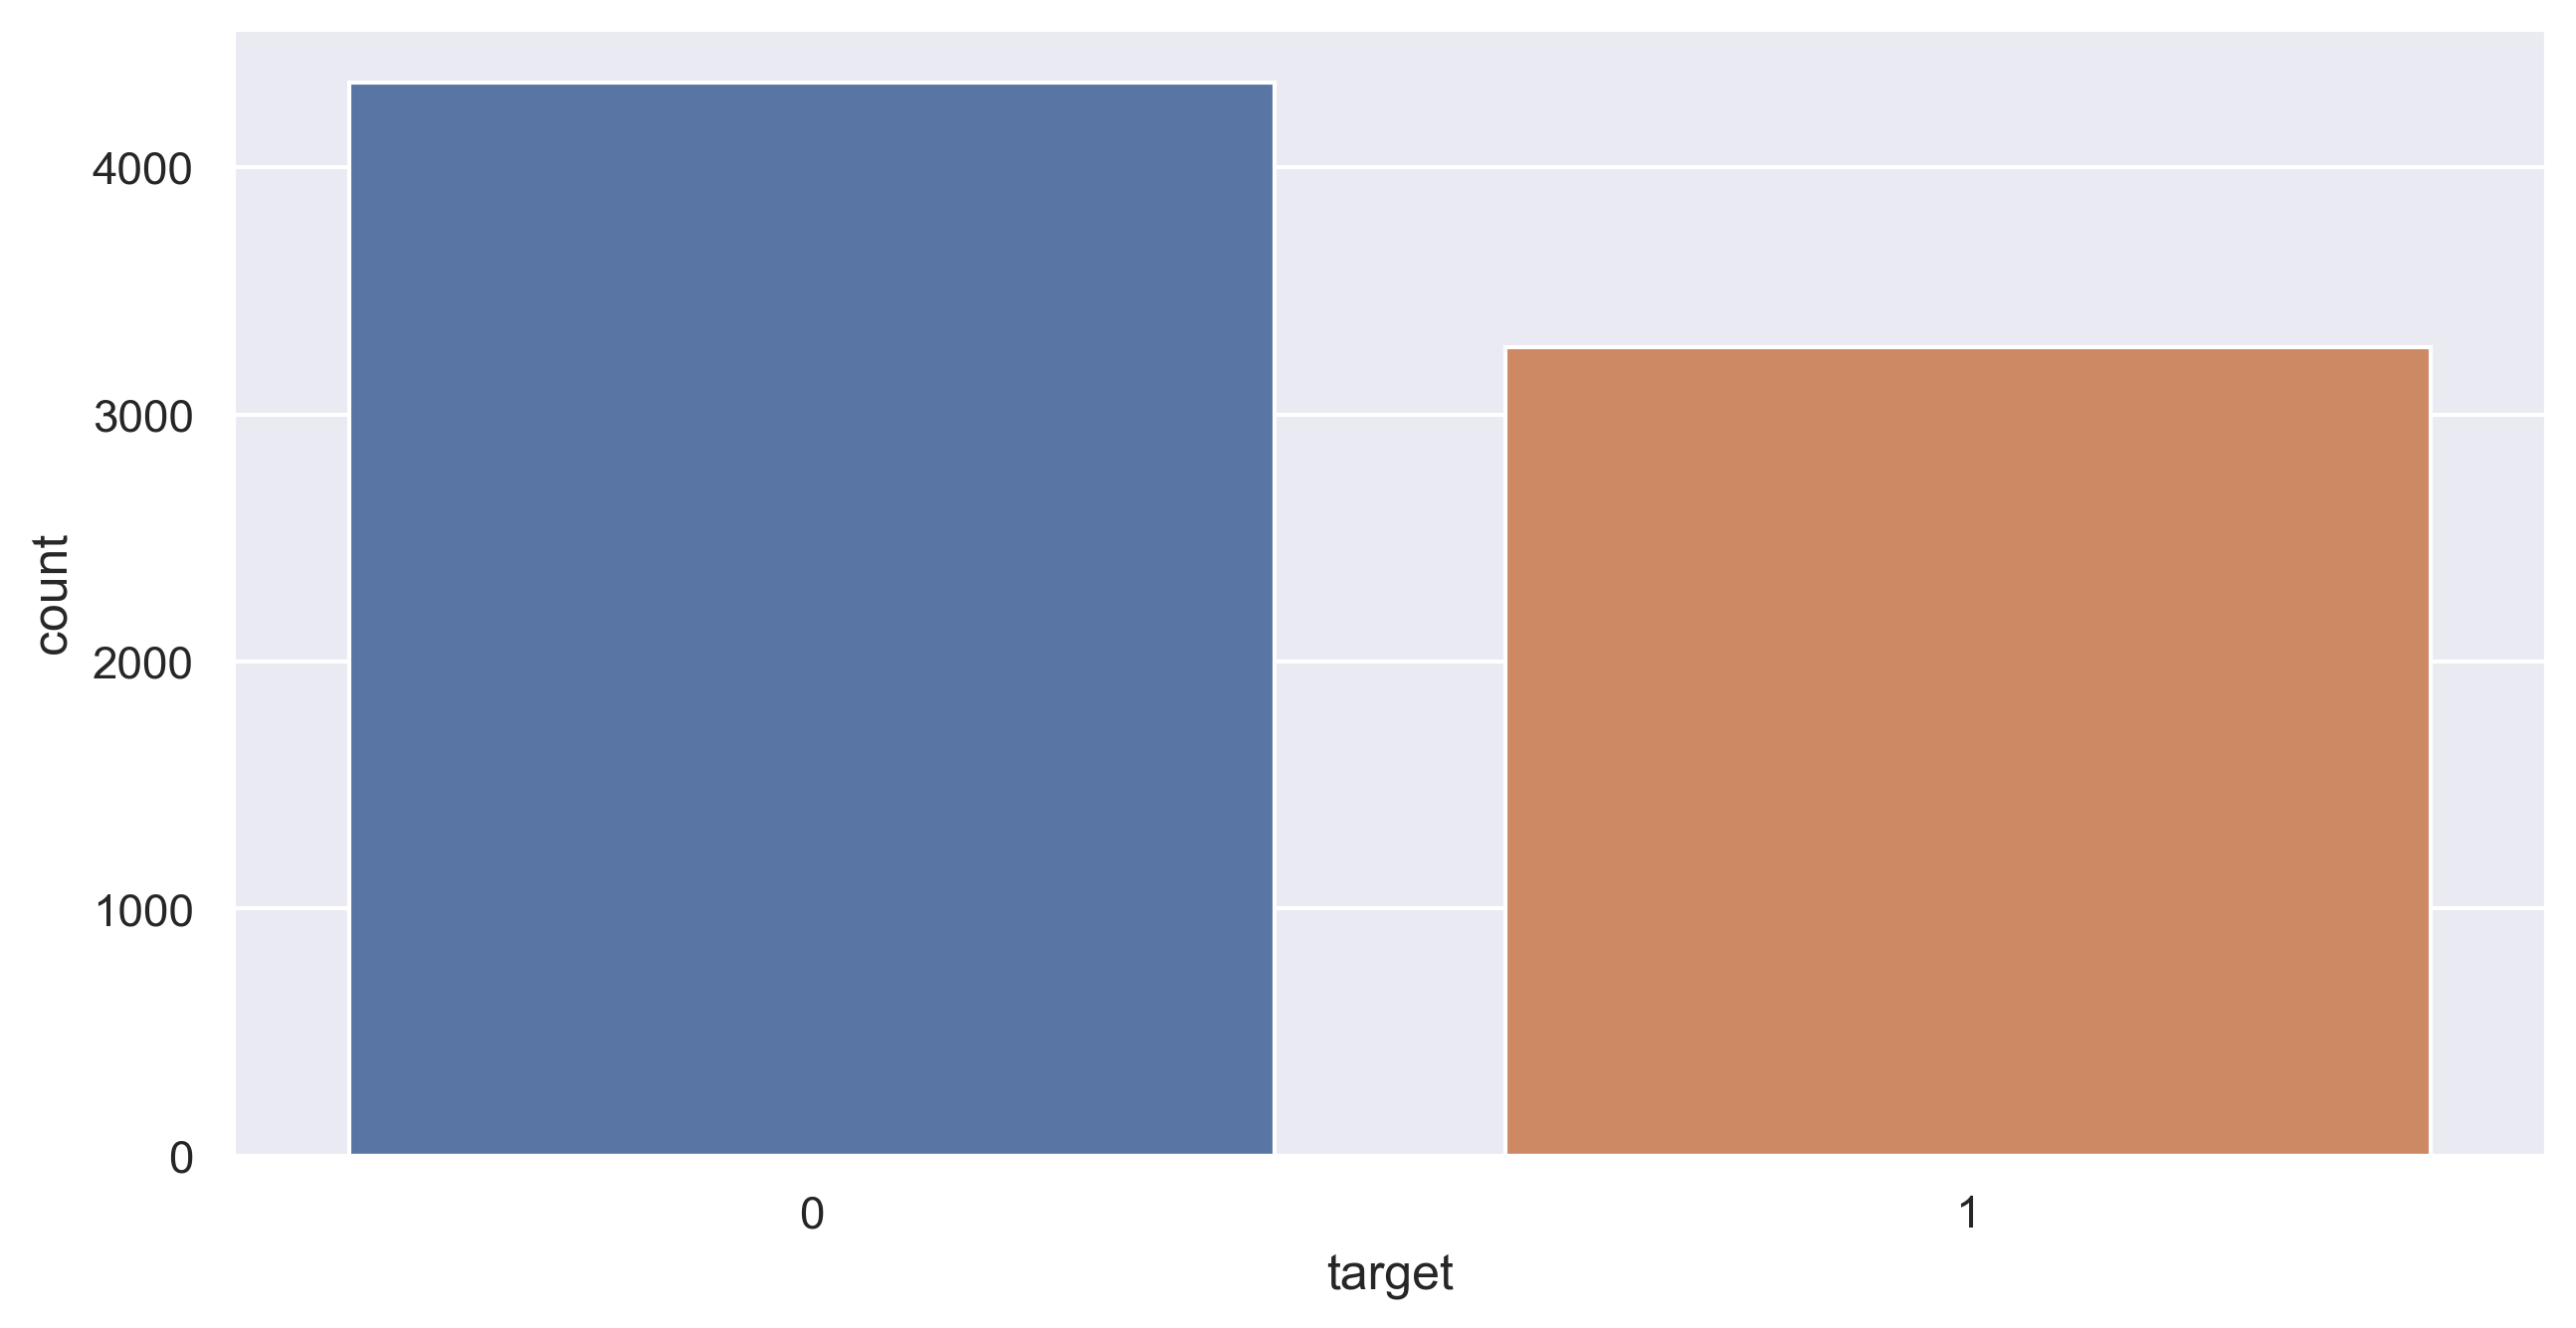

In [151]:
plt.figure(figsize=(10, 5), dpi=300)
sns.set_theme(style="darkgrid")
sns.countplot(x=data['target'])
None

In [152]:
data.keyword.value_counts()[0:10]

               61
fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
evacuate       40
fear           40
Name: keyword, dtype: int64

In [153]:
most_words = data.keyword.value_counts()[0:10].to_dict().keys()
data_x = data.loc[data.keyword.isin(most_words)]

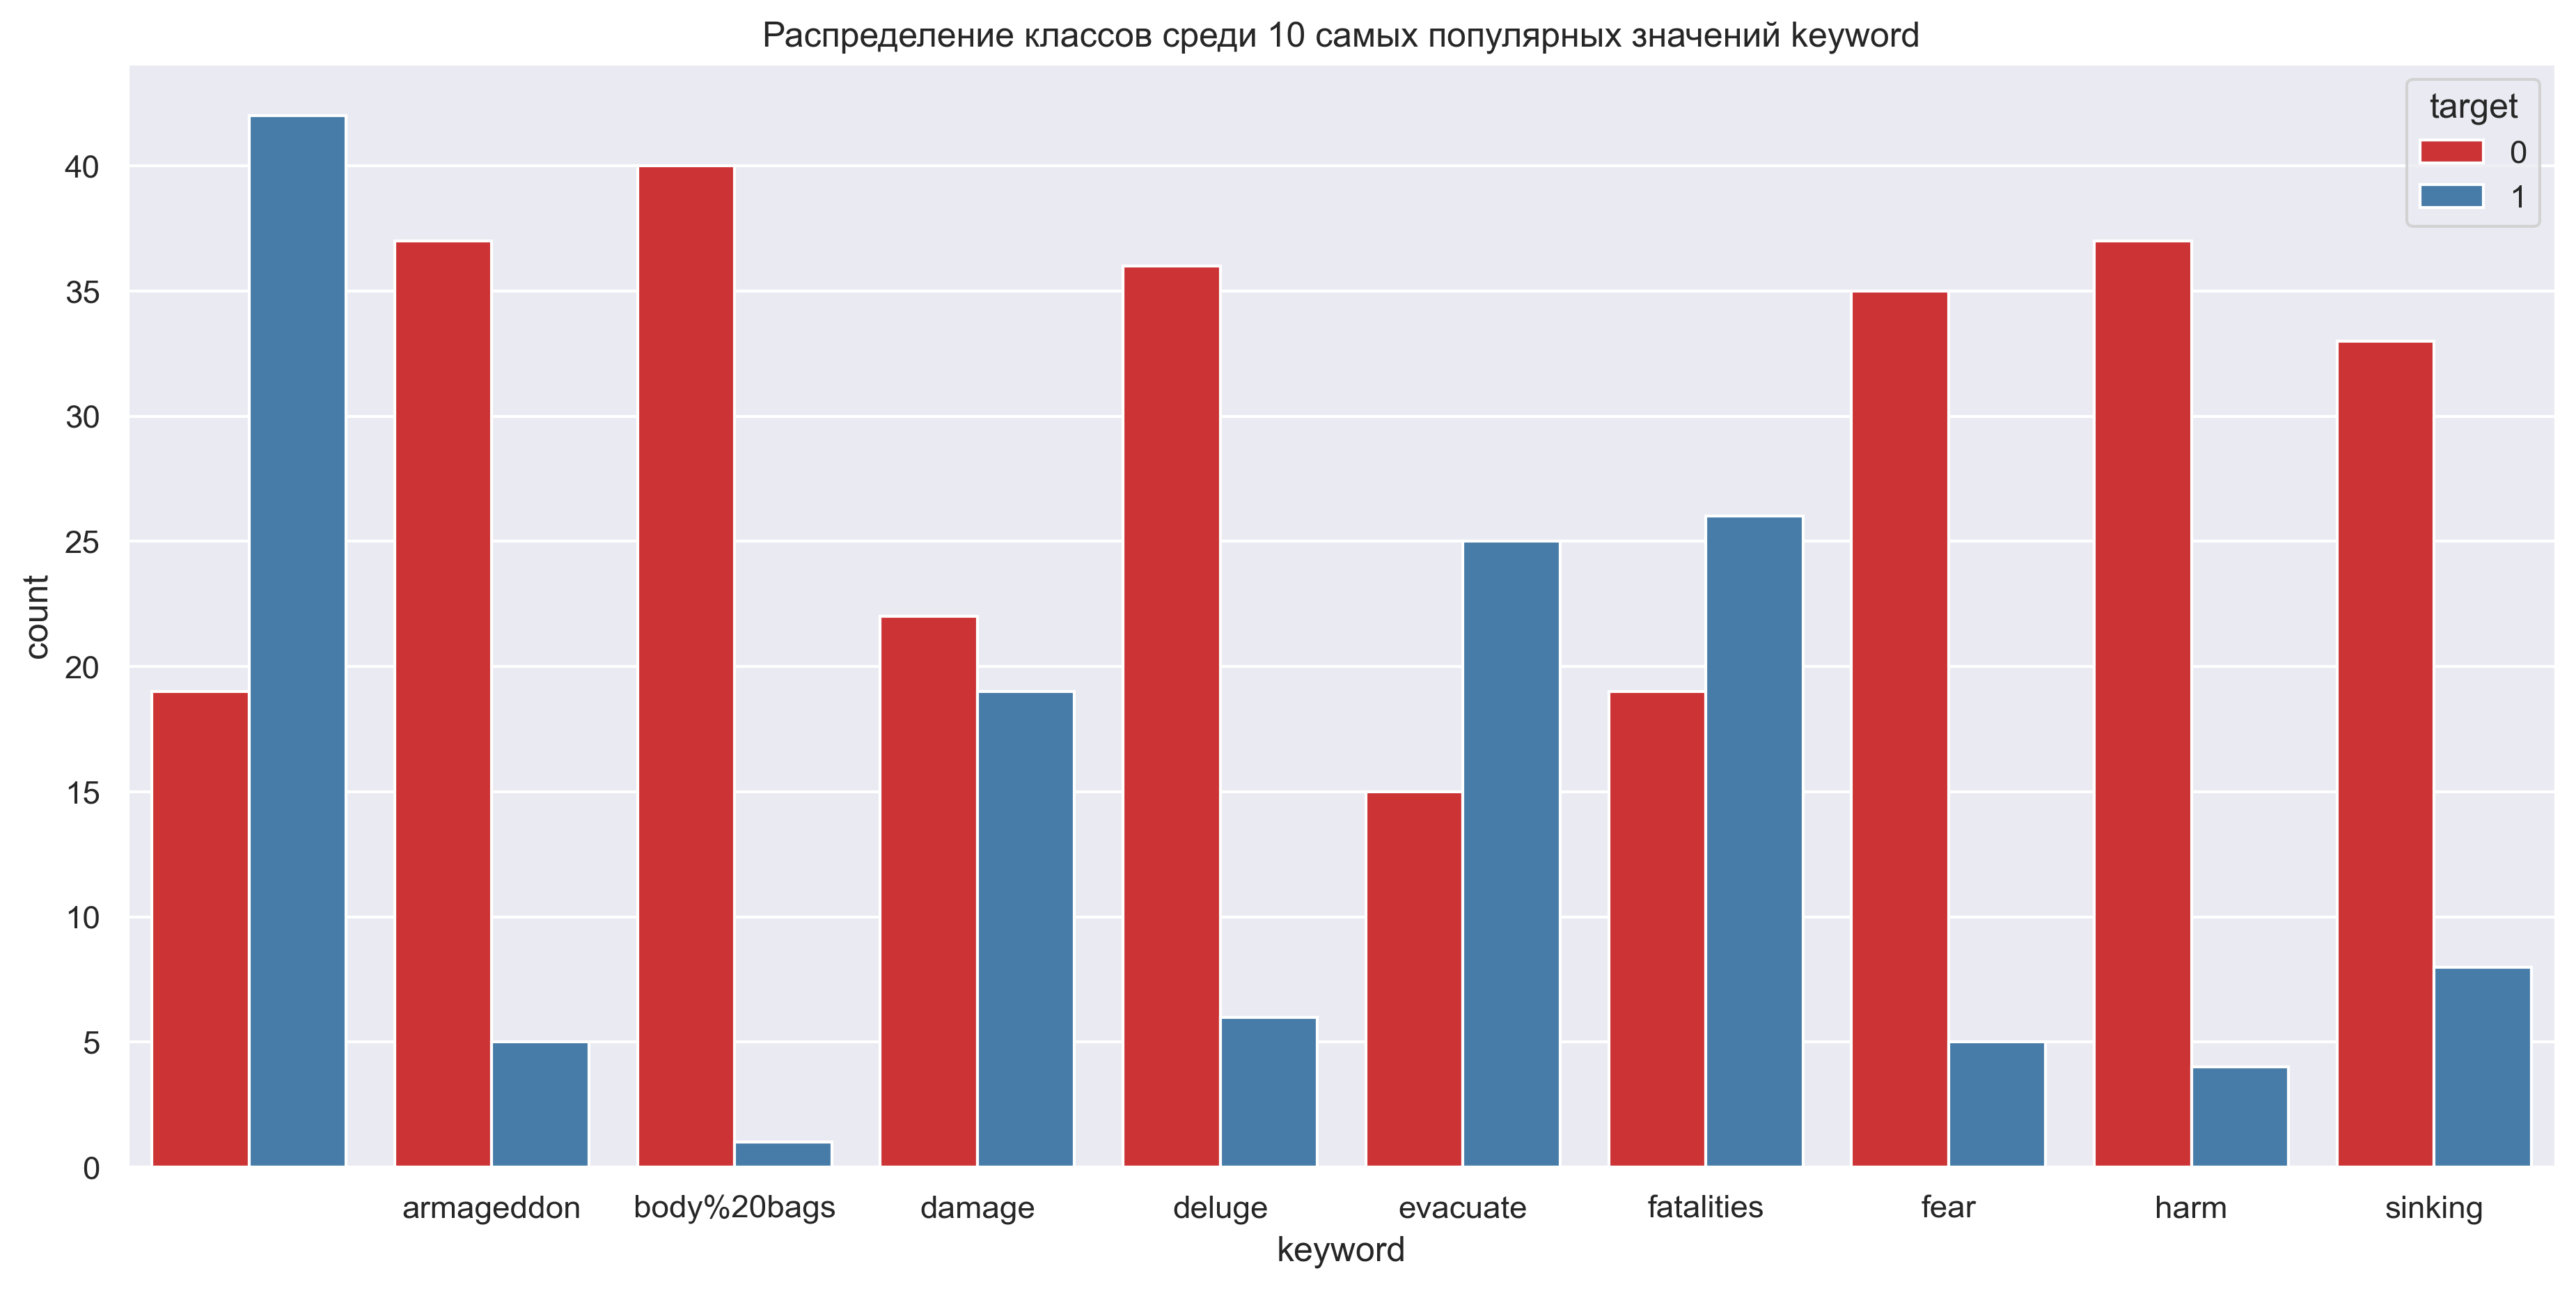

In [154]:
plt.figure(figsize=(15, 7), dpi=300)
plt.title('Распределение классов среди 10 самых популярных значений keyword')
sns.countplot(data=data_x, x="keyword", hue="target", palette="Set1")
None

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [155]:
data['concated'] = data['keyword'] + data['location'] + data['text']
data.iloc[100]

id                                                        144
keyword                                              accident
location                                                   UK
text        .@NorwayMFA #Bahrain police had previously die...
target                                                      1
concated    accidentUK.@NorwayMFA #Bahrain police had prev...
Name: 100, dtype: object

In [156]:
x_train, x_test, y_train, y_test = train_test_split(
    data['concated'], data['target'], test_size=0.3, random_state=42)

## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [157]:
vec = CountVectorizer()
bow = vec.fit_transform(x_train)
bow.shape

(5329, 22738)

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [158]:
def f5(vocabulary):
    digits = 0
    punc = 0
    hashtags = 0
    for word in a:
        if set(word) & set('0123456789'):
            digits += 1
        if set(word) & set(list(punctuation)):
            punc += 1
        if word[0] == ('#' or '@'):
            hashtags += 1
    return digits, punc, hashtags
a = vec.vocabulary_
f5(a)

(4590, 317, 0)

## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [159]:
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer
tknzr = TweetTokenizer()
vect = CountVectorizer(tokenizer=tknzr.tokenize)
bow2 = vect.fit_transform(x_train)
b = vect.vocabulary_
f5(b)

(4590, 317, 0)

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [160]:
def custom_token(text):
    tknzr = TweetTokenizer()
    v = []
    for i in text:
        #0
        i = i.lower()
        #1
        vv = tknzr.tokenize(i)
        v.extend(vv)
    #2
    k = 0
    for i in v:
        string_with_nonASCII = i
        encoded_string = string_with_nonASCII.encode("ascii", "ignore")
        decode_string = encoded_string.decode()
        if len(encoded_string) - len(string_with_nonASCII) != 0:
            v.remove(i)
    for i in range(len(v)):
        string_with_nonASCII = v[i]
        encoded_string = string_with_nonASCII.encode("ascii", "ignore")
        if len(encoded_string) - len(string_with_nonASCII) != 0:
            v.pop(i)
            v.append('1000000000')
            k += 1
    for i in range(k):
        v.remove('1000000000')
    #3
    stp = nltk.corpus.stopwords.words('english')
    for i in stp:
        if i in v:
            v.remove(i)
    #4
    stemmer = SnowballStemmer('english')
    text_stemmed = [stemmer.stem(w) for w in v]
    return text_stemmed

In [161]:
text = x_train[0:10]
cc = custom_token(text)
cc

['bridg',
 '%',
 '20collapseash',
 '2015',
 ':',
 'australia',
 'collaps',
 'trent',
 'bridg',
 'among',
 'worst',
 'histori',
 ':',
 'england',
 'bundl',
 'australia',
 '60',
 '...',
 'http://t.co/t5trhjuau0',
 'hailcarol',
 'stream',
 ',',
 'illinoisgreat',
 'michigan',
 'techniqu',
 'camp',
 'b1g',
 'thank',
 '@bmurph1019',
 '@hail_youtsey',
 '.',
 '@termn8r13',
 '#goblu',
 '#wrestleon',
 'http://t.co/oaskgki6qj',
 'policehouston',
 'cnn',
 ':',
 'tennesse',
 'movi',
 'theater',
 'shoot',
 'suspect',
 'kill',
 'polic',
 'http://t.co/di8elzswnr',
 'riotingstil',
 'riot',
 'in',
 'coupl',
 'hour',
 'left',
 'to',
 'for',
 'class',
 '.',
 'woundslak',
 'highlandscrack',
 'in',
 'path',
 'i',
 'wipe',
 'out',
 'morn',
 'beach',
 'run',
 '.',
 'surfac',
 'wound',
 'left',
 'elbow',
 'right',
 'knee',
 '.',
 'http://t.co/yaqrsximph',
 'airplan',
 '%',
 '20accidentsomewher',
 'out',
 'thereexpert',
 'in',
 'franc',
 'begin',
 'examin',
 'airplan',
 'debri',
 'found',
 'on',
 'reunion',
 'i

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.
2. Обучите LogisticRegression на полученных признаках.
3. Посчитайте метрику f1-score на тестовых данных.

In [162]:
vect2 = CountVectorizer(ngram_range=(1, 5), tokenizer=custom_token)
bow3 = vect2.fit_transform(x_train)
bow3_test = vect2.transform(x_test)
bow3.shape

(5329, 387406)

In [163]:
scaler = MaxAbsScaler()
bow3 = scaler.fit_transform(bow3)
bow3_test = scaler.transform(bow3_test)

In [164]:
clf = LogisticRegression(max_iter=10000, random_state=42)
clf.fit(bow3, y_train)
pred = clf.predict(bow3_test)
print(f1_score(y_test, pred))

0.7336293007769145


## Задание 9 (1 балл)

1. Повторите 7 задание, но с tf-idf векторизатором. Как изменилось качество?
2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?
3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [165]:
vect2 = TfidfVectorizer(ngram_range=(1, 5), tokenizer=custom_token, max_df=0.9, min_df=1e-4,)
bow3 = vect2.fit_transform(x_train)
bow3_test = vect2.transform(x_test)
bow3.shape

(5329, 387395)

In [166]:
scaler = MaxAbsScaler()
bow3 = scaler.fit_transform(bow3)
bow3_test = scaler.transform(bow3_test)

In [167]:
clf = LogisticRegression(max_iter=10000, random_state=42)
clf.fit(bow3, y_train)
pred = clf.predict(bow3_test)
print(f1_score(y_test, pred))

0.7441619097042034


## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 7 с HashingVectorizer, укажите количество фичей равное 5000.
2. Какой из подходов показал самый высокий результат?

In [168]:
vect2 = HashingVectorizer(ngram_range=(1, 5), tokenizer=custom_token, n_features=5000)
bow3 = vect2.fit_transform(x_train)
bow3_test = vect2.transform(x_test)
bow3.shape

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


(5329, 5000)

In [169]:
scaler = MaxAbsScaler()
bow3 = scaler.fit_transform(bow3)
bow3_test = scaler.transform(bow3_test)

In [170]:
clf = LogisticRegression(max_iter=10000, random_state=42)
clf.fit(bow3, y_train)
pred = clf.predict(bow3_test)
print(f1_score(y_test, pred))

0.6938986556359875


## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [171]:
vect2 = TfidfVectorizer(ngram_range=(1, 5), tokenizer=custom_token, max_df=0.9, min_df=1e-4,)
bow3 = vect2.fit_transform(x_train)
bow3_test = vect2.transform(x_test)

In [172]:
scaler = MaxAbsScaler()
bow3 = scaler.fit_transform(bow3)
bow3_test = scaler.transform(bow3_test)

In [173]:
clf = LogisticRegression(max_iter=10000, random_state=42, C=0.05)
clf.fit(bow3, y_train)
pred = clf.predict(bow3_test)
print(f1_score(y_test, pred))

0.7523609653725079
